In [1]:
%matplotlib inline


전이학습(Transfer Learning) 튜토리얼
====================================
**Author**: `Sasank Chilamkurthy <https://chsasank.github.io>`_
  **번역**: `박정환 <http://github.com/9bow>`_

이 튜토리얼에서는 전이학습(Transfer Learning)을 이용하여 신경망을 어떻게 학습시키는지
배워보겠습니다. 전이학습에 대해서 더 알아보시려면
`CS231n 노트 <http://cs231n.github.io/transfer-learning/>`__ 를 읽어보시면 좋습니다.

위 노트를 인용해보면,

    실제로 충분한 크기의 데이터셋을 갖추기는 상대적으로 드물기 때문에,
    (무작위 초기화를 통해) 바닥부터(from scratch) 전체 합성곱 신경망(Convolutional
    Network)를 학습하는 사람은 거의 없습니다. 대신, 매우 큰 데이터셋(예.
    100가지 분류(Category)에 대해 120만개의 이미지가 포함된 ImageNet)에서 합성곱
    신경망(ConvNet)을 미리 학습(Pretrain)한 후, 이 합성곱 신경망을 관심있는 작업
    (task of interest)을 위한 초기화(initialization) 또는 고정 특징 추출기(fixed
    feature extractor)로 사용합니다.

이러한 2가지의 주요한 전이학습 시나리오는 다음과 같습니다:

-  **합성곱 신경망의 미세조정(Finetuning)**: 무작위 초기화 대신, 신경망을
   ImageNet 1000 데이터셋 등으로 미리 학습한 신경망으로 초기화합니다. 학습의 나머지
   과정들은 평상시와 같습니다.
-  **고정 특정 추출기로써의 합성곱 신경망**: 여기서는 마지막의 완전히 연결
   (Fully-connected)된 계층을 제외한 모든 신경망의 가중치를 고정합니다. 이
   마지막의 완전히 연결된 계층은 새로운 무작위의 가중치를 갖는 계층으로 대체되어
   이 계층만 학습합니다.




In [2]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

데이터 불러오기
---------------

데이터를 불러오기 위해 torchvision과 torch.utils.data 패키지를 사용하겠습니다.

오늘 풀고자 하는 문제는 **개미** 와 **벌** 을 분류하는 모델을 학습하는 것입니다.
각각의 분류에는 75개의 검증용 이미지(validation image)가 있습니다. 일반적으로,
만약 바닥부터 학습을 한다면, 이는 일반화하기에는 아주 작은 데이터셋입니다.
하지만 전이학습을 사용할 것이므로, 합리적으로 잘 일반화해 할 수 있습니다.

이 데이터셋은 ImageNet의 아주 작은 부분(Subset)입니다.

.. Note ::
   데이터를 `여기 <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
   에서 다운로드 받아 현재 디렉토리에 압축을 푸십시오.



In [3]:
# 학습을 위한 데이터 증가(Augmentation)와 일반화하기
# 단지 검증을 위한 일반화하기
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 일부 이미지 시각화하기

데이터 증가를 이해하기 위해 일부 학습용 이미지를 시각화해보겠습니다.



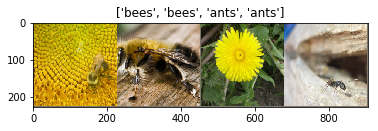

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

모델 학습하기
--------------

이제 모델을 학습하기 위한 일반 함수를 작성해보겠습니다. 여기서는 다음 내용들을
설명합니다:

-  Learning Rate 관리(Scheduling)
-  최적의 모델 구하기

아래에서 ``scheduler`` 매개변수는 ``torch.optim.lr_scheduler`` 의 LR Scheduler
객체(Object)입니다.



In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### 모델 예측값 시각화하기

일부 이미지에 대한 예측값을 보여주는 일반화된(Generic) 함수입니다.




In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

합성곱 신경망 미세조정(Finetuning)
----------------------------------

미리 학습한 모델을 불러온 후 마지막의 완전히 연결된 계층을 재설정(reset)합니다.




In [7]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### 학습 및 평가하기

CPU에서 15-25분 가량 소요될 것입니다. 그래도 GPU에서는 1분도 걸리지 않습니다.




In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5651 Acc: 0.7295
val Loss: 0.2085 Acc: 0.9412

Epoch 1/24
----------
train Loss: 0.5290 Acc: 0.7541
val Loss: 0.1748 Acc: 0.9281

Epoch 2/24
----------
train Loss: 0.5188 Acc: 0.7664
val Loss: 0.3266 Acc: 0.8758

Epoch 3/24
----------
train Loss: 0.4140 Acc: 0.8361
val Loss: 0.3098 Acc: 0.9020

Epoch 4/24
----------
train Loss: 0.3878 Acc: 0.8361
val Loss: 0.3159 Acc: 0.8824

Epoch 5/24
----------
train Loss: 0.4680 Acc: 0.8115
val Loss: 0.6172 Acc: 0.8497

Epoch 6/24
----------
train Loss: 0.3248 Acc: 0.8730
val Loss: 0.3255 Acc: 0.9020

Epoch 7/24
----------
train Loss: 0.3478 Acc: 0.8770
val Loss: 0.3127 Acc: 0.9216

Epoch 8/24
----------
train Loss: 0.2894 Acc: 0.9016
val Loss: 0.2482 Acc: 0.9216

Epoch 9/24
----------
train Loss: 0.3440 Acc: 0.8320
val Loss: 0.2959 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.2557 Acc: 0.8770
val Loss: 0.2355 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.2709 Acc: 0.8893
val Loss: 0.2060 Acc: 0.9346

Ep

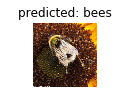

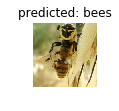

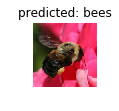

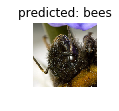

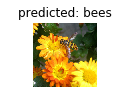

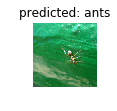

In [9]:
visualize_model(model_ft)

고정 특정 추출기로써의 합성곱 신경망
-------------------------------------

이제, 마지막 계층을 제외한 모든 신경망을 고정(freeze)할 필요가 있습니다.
``requires_grad == False`` 를 설정하여 매개변수를 고정하여 ``backward()`` 에서
경사도(gradient)가 계산되지 않도록 해야합니다.

이 부분에 대한 문서는
`여기 <http://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__
에서 확인할 수 있습니다.




In [10]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### 학습 및 평가하기

CPU에서 실행하는 경우 이전 시나리오와 비교했을 때 약 절반 가량의 시간이 소요됩니다.
이는 대부분의 신경망에서 경사도를 계산할 필요가 없을 것으로 기대합니다. 하지만,
순전파(forward)는 계산해야 할 필요가 있습니다.




In [11]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5302 Acc: 0.7008
val Loss: 0.2537 Acc: 0.9150

Epoch 1/24
----------
train Loss: 0.7124 Acc: 0.7459
val Loss: 0.2680 Acc: 0.8889

Epoch 2/24
----------
train Loss: 0.4569 Acc: 0.7992
val Loss: 0.3490 Acc: 0.8562

Epoch 3/24
----------
train Loss: 0.5923 Acc: 0.7500
val Loss: 0.1829 Acc: 0.9281

Epoch 4/24
----------
train Loss: 0.3893 Acc: 0.8238
val Loss: 0.2275 Acc: 0.9216

Epoch 5/24
----------
train Loss: 0.5660 Acc: 0.8156
val Loss: 0.3437 Acc: 0.8889

Epoch 6/24
----------
train Loss: 0.4028 Acc: 0.8402
val Loss: 0.2101 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.3134 Acc: 0.8770
val Loss: 0.2089 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3580 Acc: 0.8279
val Loss: 0.2122 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.3417 Acc: 0.8361
val Loss: 0.2381 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.3632 Acc: 0.8648
val Loss: 0.2074 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.3377 Acc: 0.8525
val Loss: 0.2199 Acc: 0.9216

Ep

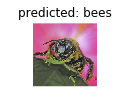

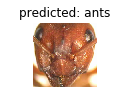

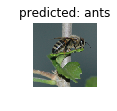

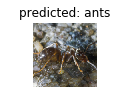

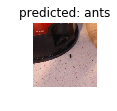

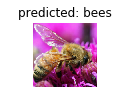

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x11de61240>>
Traceback (most recent call last):
  File "/anaconda/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 349, in __del__
    self._shutdown_workers()
  File "/anaconda/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 328, in _shutdown_workers
    self.worker_result_queue.get()
  File "/anaconda/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/anaconda/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 86, in rebuild_storage_filename
    storage = cls._new_shared_filename(manager, handle, size)
RuntimeError: Interrupted system call at /Users/soumith/minicondabuild3/conda-bld/pytorch_1524590658547/work/torch/lib/libshm/core.cpp:125


In [12]:
visualize_model(model_conv)

plt.ioff()
plt.show()